In [1]:
import sys
sys.path.insert(0, '..')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Import JAX instead of numpy
import jax
import jax.numpy as np
import jax.random as rand

# Import modified version of challenge metrics
from tomo_challenge import jax_metrics as metrics

# Import tools from jax-cosmo
from jax_cosmo.redshift import kde_nz

Found classifier IBandOnly
Found classifier NeuralNetwork
Found classifier Random
Found classifier RandomForest


## Loading the data

In [3]:
from tomo_challenge.data import load_data, load_redshift
from sklearn.preprocessing import StandardScaler, RobustScaler
features_scaler = RobustScaler()

data = load_data('../data/training.hdf5','riz',colors=True, errors=True, array=True)
m = (data[:,0] <32) & (data[:,1] <32) & (data[:,2] <32)
data = data[m]

features = np.clip(np.array(features_scaler.fit_transform(data)),-4,4)
labels = np.array(load_redshift('../data/training.hdf5'))[m]

../tomo_challenge/data.py:76: UserWarning: Setting inf (undetected) bands to mag=30
  warnings.warn("Setting inf (undetected) bands to mag=30")


In [4]:
# Let's grab some data
batch_size = 10000
# Let's grab some data
batch_labels = labels[:batch_size]
batch_features = features[:batch_size]

In [5]:
nz = kde_nz(batch_labels, np.ones_like(batch_labels),  bw=0.01)

Text(0.5, 0, 'redshift z')

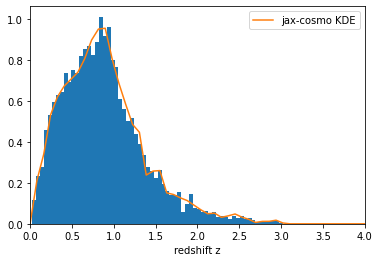

In [6]:
z = np.linspace(0,4)
hist(batch_labels, 64, density=True)
plot(z, nz(z), label='jax-cosmo KDE')
xlim(0,4)
legend()
xlabel('redshift z')

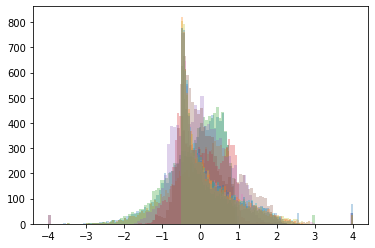

In [7]:
for i in range(12):
    hist(batch_features[:,i],100, alpha=0.3)

## Create a neural network classifier

In [8]:
from flax import nn
from flax import optim

In [9]:
nbins=3
# Here is a trivial classifier for 2 bins
class BinningNN(nn.Module):
    def apply(self, x):
        """
        Takes as an input the features to use for binning
        """
        net = nn.Dense(x, 500, name='fc1')
        net = nn.leaky_relu(net)
        net = nn.BatchNorm(net)
        net = nn.Dense(net, 500, name='fc2')
        net = nn.leaky_relu(net)
        net = nn.BatchNorm(net)
        net = nn.Dense(net, 500, name='fc3')
        net = nn.leaky_relu(net)
        net = nn.BatchNorm(net)
        # The output of the model should be a gumbell softmax layer
        return nn.softmax(nn.Dense(net, nbins))

In [10]:
@jax.jit
def train_step(optimizer, batch):
    def loss_fn(model):
        w = model(batch['features'])
        return -metrics.compute_snr_score(w, batch['labels'])
    loss, g = jax.value_and_grad(loss_fn)(optimizer.target)
    optimizer = optimizer.apply_gradient(g)
    return optimizer, loss

In [11]:
# Let's get some initial weights
_, initial_params = BinningNN.init_by_shape( rand.PRNGKey(0), [((1, 12), np.float32)])
model = nn.Model(BinningNN, initial_params)

In [12]:
optimizer = optim.Momentum(learning_rate=0.001, beta=0.9).create(model)

In [13]:
import numpy as onp
batch_size = 10000
def get_batch():
    inds = onp.random.choice(len(labels), batch_size)
    return {'labels': labels[inds], 'features': features[inds]}

In [14]:
# Before optimization, this is what the neural network gets us
batch = get_batch()
w  = optimizer.target(batch['features'])
nzs = [kde_nz(batch['labels'], w[:,i], bw=0.01, zmax=4.) for i in range(nbins)]

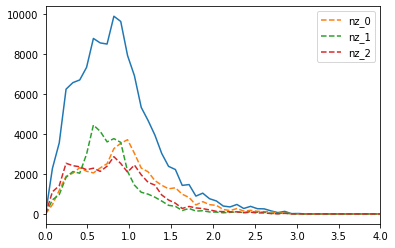

In [15]:
z = np.linspace(0,4)
nz_total = kde_nz(batch['labels'], np.ones_like(batch['labels']), bw=0.01)
plot(z, nz_total(z)*len(nz_total.params[0]))
for i, nz in enumerate(nzs):
    plot(z, nz(z)*nz.params[1].sum(), '--', label='nz_%d'%i)
xlim(0,4)
legend()

All the bins are overlapping and pretty much the same because the NN
is randomly assigning galaxies to bin, without strong hints from the
photometry

In [16]:
losses = []

In [17]:
# Now let's train the model for a little while
for i in range(1500):
    optimizer, loss = train_step(optimizer, get_batch())
    losses.append(loss)
    if i%100 == 0:
        print('Loss : %f'%loss)

/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5591: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


Loss : -590.973816
Loss : -893.604553
Loss : -892.638184
Loss : -891.500549
Loss : -889.718262
Loss : -893.868958
Loss : -891.760742
Loss : -891.517090
Loss : -893.302673
Loss : -898.416748
Loss : -894.637329
Loss : -895.955505
Loss : -892.862488
Loss : -893.471008
Loss : -897.341125


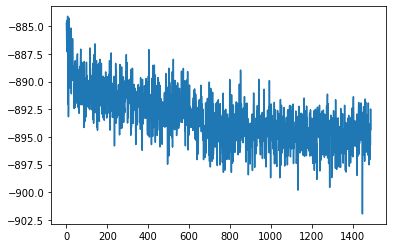

In [18]:
plot(losses[10:])

In [19]:
# Sweet :-D let's see if it did anything
batch = get_batch()
w  = optimizer.target(batch['features'])
nzs = [kde_nz(batch['labels'], w[:,i], bw=0.01, zmax=4.) for i in range(nbins)]

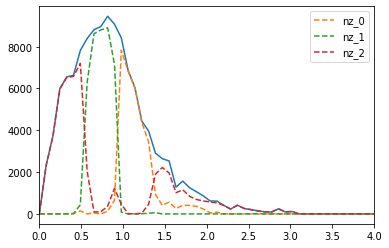

In [20]:
z = np.linspace(0,4)
nz_total = kde_nz(batch['labels'], np.ones_like(batch['labels']), bw=0.01)
plot(z, nz_total(z)*len(nz_total.params[0]))
for i, nz in enumerate(nzs):
    plot(z, nz(z)*nz.params[1].sum(), '--', label='nz_%d'%i)
xlim(0,4)
legend()

In [33]:
# Exporting the trained model
from flax import serialization
import pickle

with open('BinningNN5b.pckl', 'wb') as file:
    pickle.dump(serialization.to_bytes(optimizer.target), file)